Percentage of variance retained after PCA reduction to 3D: 100.00%
Initial Centroids:
            0         1         2         3
PC1 -0.377613  0.035837 -0.334337 -0.479977
PC2 -0.293878 -0.201191 -0.257388 -0.285744
PC3 -0.026048 -0.005932 -0.014673 -0.015352
Cluster label counts:
3    98
1    57
2    52
0     8
dtype: int64
Updated Centroids:
            0         1         2         3
PC1 -0.396092  1.160641 -0.331467 -0.466853
PC2 -0.273860  0.604853 -0.108983 -0.271619
PC3  0.014783  0.013266 -0.009986 -0.003624
Silhouette Score for k=4: 0.1942


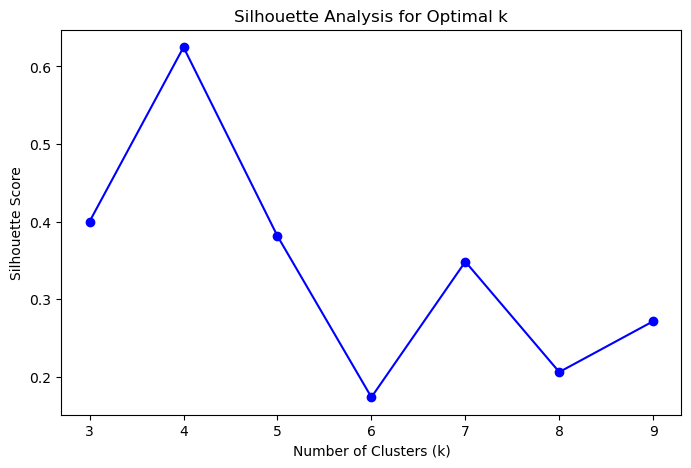

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Permanently change pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Read the dataset
DF = pd.read_csv('cleaned_departures_development.csv')

# Drop unnecessary columns
DF = DF.drop(["Name", "Area"], axis=1)
DF = DF.dropna()

# Extract and drop label column
DFLabel = DF["Development_Level"]
DF = DF.drop(["Development_Level"], axis=1)

# Normalize the data
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF)
DF = pd.DataFrame(DF_scaled, columns=DF.columns)

# Perform PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
DF_pca = pca.fit_transform(DF)
DF_pca = pd.DataFrame(DF_pca, columns=['PC1', 'PC2', 'PC3'])

# Calculate and print explained variance
explained_variance = np.sum(pca.explained_variance_ratio_) * 100
print(f"Percentage of variance retained after PCA reduction to 3D: {explained_variance:.2f}%")

# Clustering parameters
k = 4

# Function to initialize random centroids
def RandomCentroidInit(DF, k):
    MyCentroids = []
    for i in range(k):
        nextcentroid = DF.apply(lambda x: float(x.sample()))
        MyCentroids.append(nextcentroid)
    return pd.concat(MyCentroids, axis=1)

# Initialize centroids
MyCentroids = RandomCentroidInit(DF_pca, k)
print("Initial Centroids:")
print(MyCentroids)

# Function to label each data point with the closest centroid
def Label_Data(DF, MyCentroids):
    dist = MyCentroids.apply(lambda x: np.sqrt(((DF - x) ** 2).sum(axis=1)))
    labels = dist.idxmin(axis=1)
    return labels

# Assign initial labels
cluster_labels = Label_Data(DF_pca, MyCentroids)

# Print cluster counts
print("Cluster label counts:")
print(cluster_labels.value_counts())

# Function to update centroids based on current clusters
def Updated_Centroids(DF, cluster_labels, k):
    Cluster_Means = DF.groupby(cluster_labels).apply(lambda x: x.mean()).T
    return Cluster_Means

# Update centroids
MyCentroids = Updated_Centroids(DF_pca, cluster_labels, k)
print("Updated Centroids:")
print(MyCentroids)

# Compute Silhouette Score
silhouette_avg = silhouette_score(DF_pca, cluster_labels)
print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")

# Plot Silhouette Scores for different values of k
silhouette_scores = []
k_values = range(3, 10)  # Testing k from 2 to 9

for k in k_values:
    MyCentroids = RandomCentroidInit(DF_pca, k)
    cluster_labels = Label_Data(DF_pca, MyCentroids)
    silhouette_scores.append(silhouette_score(DF_pca, cluster_labels))

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


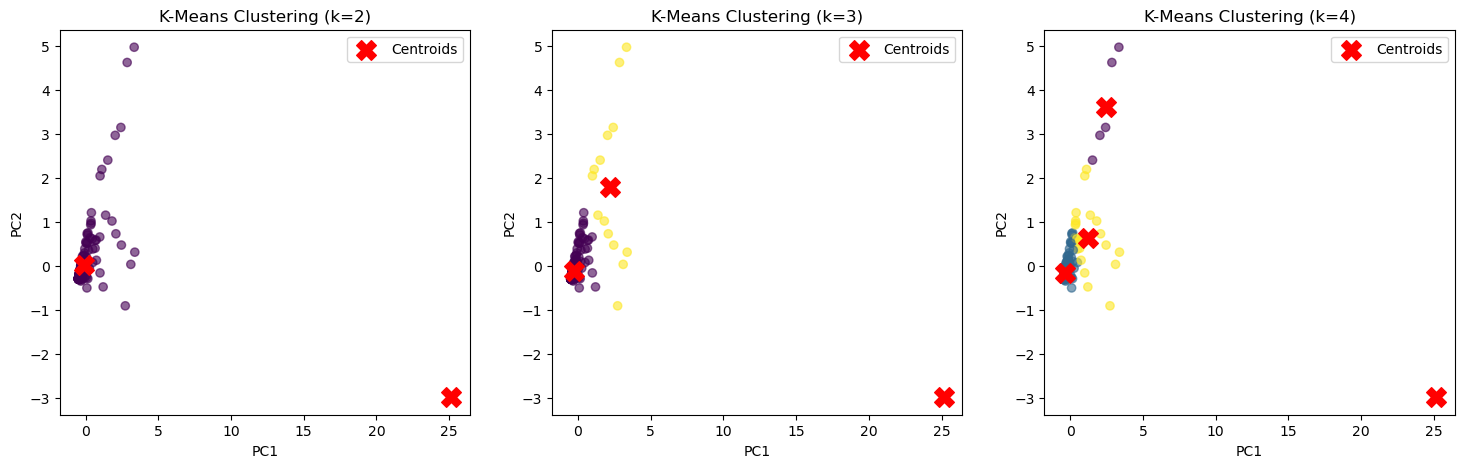

In [7]:
# Create subplots for clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Apply K-Means for selected k values and plot
for i, k in enumerate(best_k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(DF_pca)
    centroids = kmeans.cluster_centers_
 # Scatter plot of clusters
    axes[i].scatter(DF_pca["PC1"], DF_pca["PC2"], c=cluster_labels, cmap='viridis', alpha=0.6)
    axes[i].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")
    axes[i].set_title(f"K-Means Clustering (k={k})")
    axes[i].legend()

plt.show()

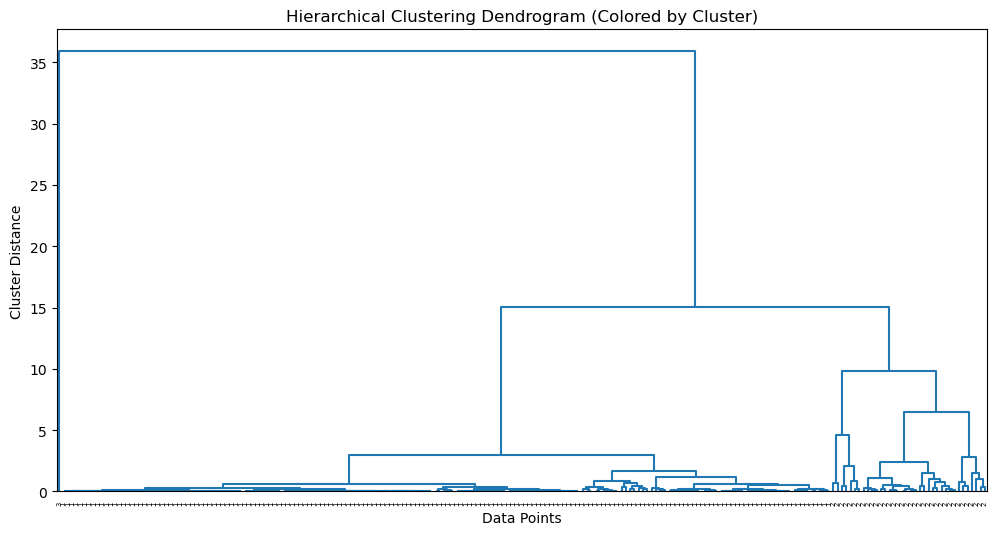

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
DF = pd.read_csv('cleaned_departures_development.csv')

# Drop unnecessary columns
DF = DF.drop(["Name", "Area"], axis=1)
DF = DF.dropna()

# Extract and drop label column
DFLabel = DF["Development_Level"]
DF = DF.drop(["Development_Level"], axis=1)

# Normalize the data
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF)
DF = pd.DataFrame(DF_scaled, columns=DF.columns)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
DF_pca = pca.fit_transform(DF)
DF_pca = pd.DataFrame(DF_pca, columns=['PC1', 'PC2', 'PC3'])

# Compute the linkage matrix for hierarchical clustering
linkage_matrix = linkage(DF_pca, method='ward')

# Set the number of clusters based on the dendrogram
k = 3  # Number of clusters you want, based on your analysis

# Create the clusters using fcluster (flat cluster)
cluster_assignments = fcluster(linkage_matrix, t=k, criterion='maxclust')

# Create the dendrogram and color it by clusters
plt.figure(figsize=(12, 6))

# Generate dendrogram with color_threshold to control the color of branches
dendrogram(linkage_matrix,
           color_threshold=0,  # Color branches based on distance
           labels=cluster_assignments.astype(str))  # Show cluster assignments as labels

plt.xlabel("Data Points")
plt.ylabel("Cluster Distance")
plt.title("Hierarchical Clustering Dendrogram (Colored by Cluster)")
plt.show()


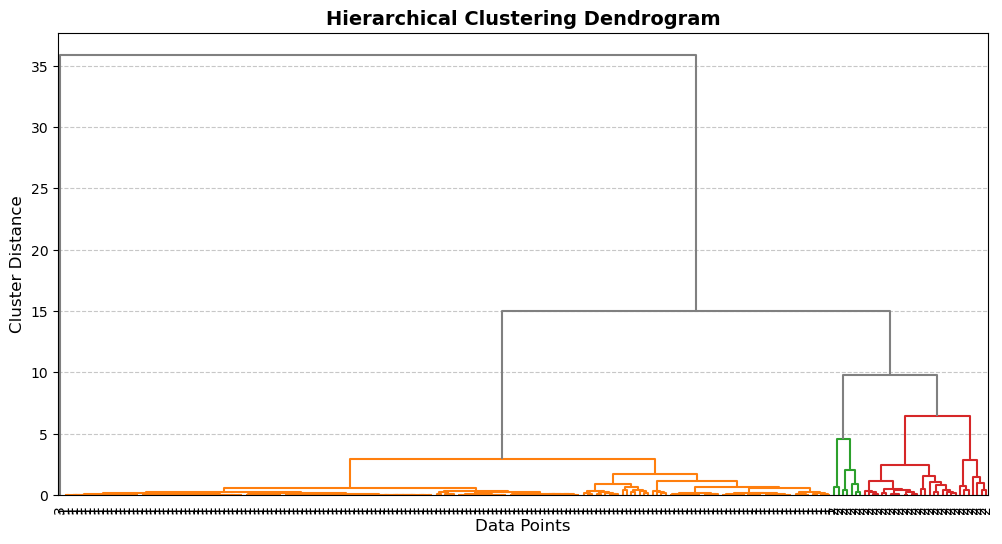

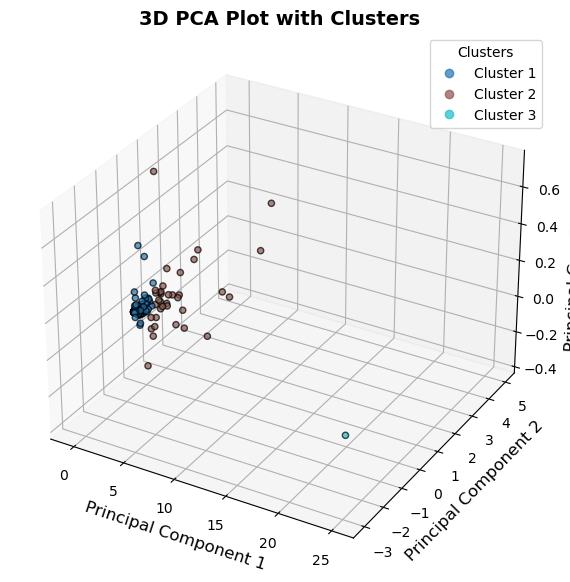

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load dataset
DF = pd.read_csv('cleaned_departures_development.csv')

# Drop unnecessary columns
DF = DF.drop(["Name", "Area"], axis=1)
DF = DF.dropna()

# Extract and drop label column
DFLabel = DF["Development_Level"]
DF = DF.drop(["Development_Level"], axis=1)

# Normalize the data
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF)
DF = pd.DataFrame(DF_scaled, columns=DF.columns)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
DF_pca = pca.fit_transform(DF)
DF_pca = pd.DataFrame(DF_pca, columns=['PC1', 'PC2', 'PC3'])

# Compute the linkage matrix for hierarchical clustering
linkage_matrix = linkage(DF_pca, method='ward')

# Set the number of clusters based on the dendrogram
k = 3  # Adjust based on your analysis

# Create the clusters using fcluster (flat cluster)
cluster_assignments = fcluster(linkage_matrix, t=k, criterion='maxclust')

# Assign cluster labels to PCA DataFrame for visualization
DF_pca['Cluster'] = cluster_assignments

# 📌 **Enhanced Dendrogram with Color-Coded Clusters**
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix,
           color_threshold=linkage_matrix[-k, 2],  # Color clusters distinctly
           labels=cluster_assignments.astype(str),
           above_threshold_color='gray')  # Unclustered branches in gray

plt.xlabel("Data Points", fontsize=12)
plt.ylabel("Cluster Distance", fontsize=12)
plt.title("Hierarchical Clustering Dendrogram", fontsize=14, fontweight="bold")
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 **3D Scatter Plot of PCA Components with Cluster Colors**
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Define color palette
palette = sns.color_palette("tab10", k)

# Scatter plot of PCA components
scatter = ax.scatter(DF_pca['PC1'], DF_pca['PC2'], DF_pca['PC3'],
                     c=DF_pca['Cluster'], cmap='tab10', alpha=0.7, edgecolors='k')

ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_zlabel("Principal Component 3", fontsize=12)
ax.set_title("3D PCA Plot with Clusters", fontsize=14, fontweight="bold")

# Create legend for clusters
legend_labels = [f'Cluster {i}' for i in range(1, k + 1)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")

plt.show()


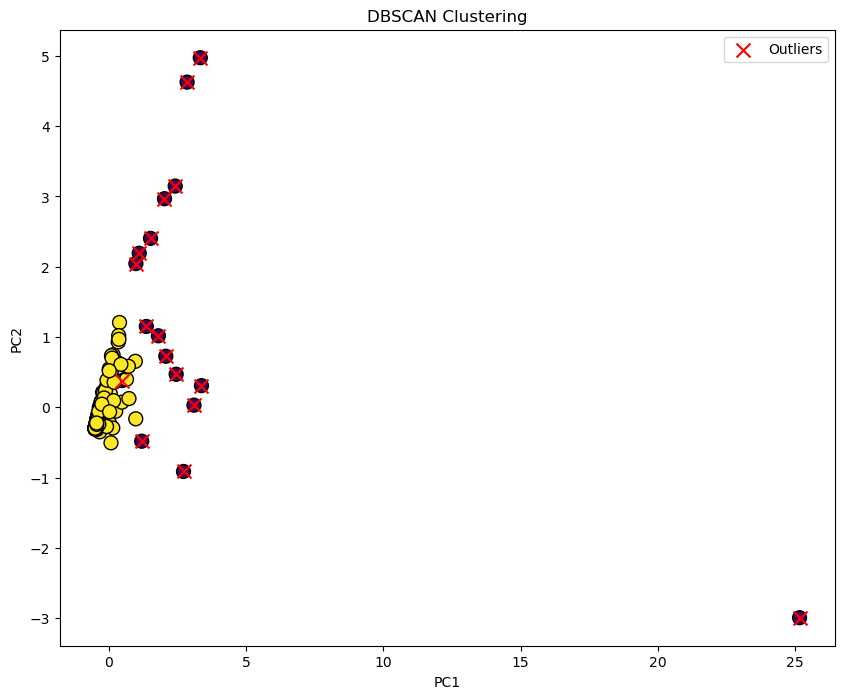

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Load dataset
DF = pd.read_csv('cleaned_departures_development.csv')

# Drop unnecessary columns
DF = DF.drop(["Name", "Area"], axis=1)
DF = DF.dropna()

# Extract and drop label column
DFLabel = DF["Development_Level"]
DF = DF.drop(["Development_Level"], axis=1)

# Normalize the data
scaler = StandardScaler()
DF_scaled = scaler.fit_transform(DF)
DF = pd.DataFrame(DF_scaled, columns=DF.columns)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
DF_pca = pca.fit_transform(DF)
DF_pca = pd.DataFrame(DF_pca, columns=['PC1', 'PC2', 'PC3'])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(DF_pca)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(DF_pca['PC1'], DF_pca['PC2'], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=100)

# Highlight outliers (cluster label -1)
outliers = cluster_labels == -1
plt.scatter(DF_pca[outliers]['PC1'], DF_pca[outliers]['PC2'], c='red', marker='x', s=100, label='Outliers')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

